### 缺失值处理

In [1]:
#coding:utf-8
#导入warnings包，利用过滤器来实现忽略警告语句。
import warnings
warnings.filterwarnings('ignore')

# GBDT
from sklearn.ensemble import GradientBoostingRegressor
# XGBoost
import xgboost as xgb
# LightGBM
import lightgbm as lgb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
import pickle
import multiprocessing
from sklearn.preprocessing import StandardScaler
ss = StandardScaler() 
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,LinearRegression,LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
#载入数据
data_train = pd.read_csv('../data/train_data.csv')
data_train['Type'] = 'Train'
data_test = pd.read_csv('../data/test_a.csv')
data_test['Type'] = 'Test'
data_all = pd.concat([data_train, data_test], ignore_index=True)

主要思路分析  
虽然这步骤是缺失值处理，但还会涉及到一些最最基础的数据处理。  

缺失值处理  
缺失值的处理手段大体可以分为：删除、填充、映射到高维(当做类别处理)。  
详细的请自行查找相关资料学习。  
根据任务一，直接找到的缺失值情况是pu和pv；但是，根据特征nunique分布的分析，可以发现rentType存在"--"的情况，这也算是一种缺失值。  
此外，诸如rentType的"未知方式"；houseToward的"暂无数据"等，本质上也算是一种缺失值，但是对于这些缺失方式，我们可以把它当做是特殊的一类处  理，而不需要去主动修改或填充值。  

将rentType的"--"转换成"未知方式"类别；  
pv/pu的缺失值用均值填充；  
buildYear存在"暂无信息"，将其用众数填充。  
  
转换object类型数据  
这里直接采用LabelEncoder的方式编码，详细的编码方式请自行查阅相关资料学习。  
时间字段的处理  
buildYear由于存在"暂无信息",所以需要主动将其转换int类型；  
tradeTime，将其分割成月和日。  
删除无关字段  
ID是唯一码，建模无用，所以直接删除；  
city只有一个SH值，也直接删除；  
tradeTime已经分割成月和日，删除原来字段  

In [4]:
def preprocessingData(data):
    # 填充缺失值
    data['rentType'][data['rentType'] == '--'] = '未知方式'
    
    # 转换object类型数据
    columns = ['rentType','communityName','houseType', 'houseFloor', 'houseToward', 'houseDecoration',  'region', 'plate']
    
    for feature in columns:
        data[feature] = LabelEncoder().fit_transform(data[feature])

    # 将buildYear列转换为整型数据
    buildYearmean = pd.DataFrame(data[data['buildYear'] != '暂无信息']['buildYear'].mode())
    data.loc[data[data['buildYear'] == '暂无信息'].index, 'buildYear'] = buildYearmean.iloc[0, 0]
    data['buildYear'] = data['buildYear'].astype('int')

    # 处理pv和uv的空值
    data['pv'].fillna(data['pv'].mean(), inplace=True)
    data['uv'].fillna(data['uv'].mean(), inplace=True)
    data['pv'] = data['pv'].astype('int')
    data['uv'] = data['uv'].astype('int')

    # 分割交易时间
    def month(x):
        month = int(x.split('/')[1])
        return month
    def day(x):
        day = int(x.split('/')[2])
        return day
    data['month'] = data['tradeTime'].apply(lambda x: month(x))
    data['day'] = data['tradeTime'].apply(lambda x: day(x))
    
    # 去掉部分特征
    data.drop('city', axis=1, inplace=True)
    data.drop('tradeTime', axis=1, inplace=True)
    data.drop('ID', axis=1, inplace=True)
    return data

data_train = preprocessingData(data_train)


异常值处理  
主要思路分析  
这里主要针对area和tradeMoney两个维度处理。  
针对tradeMoney，这里采用的是IsolationForest模型自动处理；  
针对areahetotalFloor是主观+数据可视化的方式得到的结果。  

参考资料：  
iForest （Isolation Forest）孤立森林 异常检测 入门篇  

In [5]:
# clean data
def IF_drop(train):
    IForest = IsolationForest(contamination=0.01)
    IForest.fit(train["tradeMoney"].values.reshape(-1,1))
    y_pred = IForest.predict(train["tradeMoney"].values.reshape(-1,1))
    drop_index = train.loc[y_pred==-1].index
    print(drop_index)
    train.drop(drop_index,inplace=True)
    return train

data_train = IF_drop(data_train)

Int64Index([   62,    69,   128,   131,   228,   246,   261,   266,   277,
              297,
            ...
            39228, 39319, 39347, 39352, 39434, 39563, 41080, 41083, 41233,
            41241],
           dtype='int64', length=441)


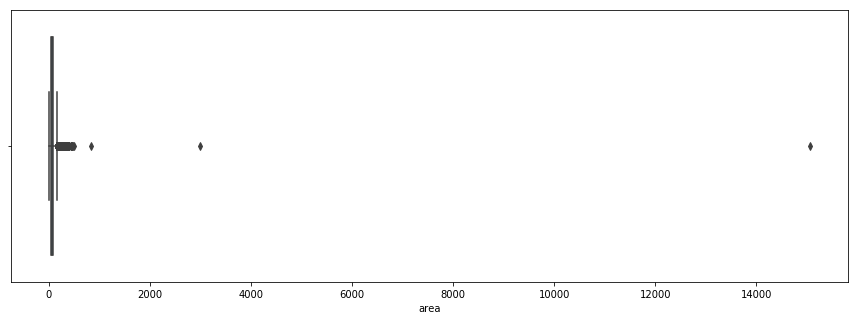

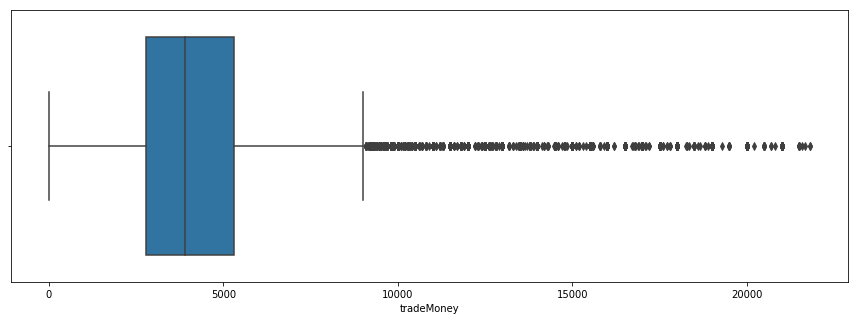

In [6]:
# 处理异常值后再次查看面积和租金分布图
plt.figure(figsize=(15,5))
sns.boxplot(data_train.area)
plt.show()
plt.figure(figsize=(15,5))
sns.boxplot(data_train.tradeMoney),
plt.show()

深度清洗  
主要思路分析  
针对每一个region的数据，对area和tradeMoney两个维度进行深度清洗。 采用主观+数据可视化的方式。  

In [8]:
def cleanData(data):
    data.drop(data[(data['region']=='RG00001') & (data['tradeMoney']<1000)&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['tradeMoney']>25000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>250)&(data['tradeMoney']<20000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>400)&(data['tradeMoney']>50000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>100)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00002') & (data['area']<100)&(data['tradeMoney']>60000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['area']<300)&(data['tradeMoney']>30000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<500)&(data['area']<50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<1500)&(data['area']>100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']<2000)&(data['area']>300)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['tradeMoney']>5000)&(data['area']<20)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['area']>600)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['tradeMoney']<1000)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']<200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']<2000)&(data['area']>180)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>50000)&(data['area']<200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['area']>200)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00007') & (data['area']>100)&(data['tradeMoney']<2500)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['area']>200)&(data['tradeMoney']>25000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['area']>400)&(data['tradeMoney']<15000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']<3000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']>7000)&(data['area']<75)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['tradeMoney']>12500)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['area']>400)&(data['tradeMoney']>20000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008') & (data['tradeMoney']<2000)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['area']>300)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['area']>100)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00011') & (data['tradeMoney']<10000)&(data['area']>390)].index,inplace=True)
    data.drop(data[(data['region']=='RG00012') & (data['area']>120)&(data['tradeMoney']<5000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']<100)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']>400)&(data['tradeMoney']>50000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']>80)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['area']>300)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<1300)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<8000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<1000)&(data['area']>20)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']>25000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['tradeMoney']<20000)&(data['area']>250)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>30000)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']<50000)&(data['area']>600)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005') & (data['tradeMoney']>50000)&(data['area']>350)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']>4000)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']<600)&(data['area']>100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['area']>165)].index,inplace=True)
    data.drop(data[(data['region']=='RG00012') & (data['tradeMoney']<800)&(data['area']<30)].index,inplace=True)
    data.drop(data[(data['region']=='RG00007') & (data['tradeMoney']<1100)&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['tradeMoney']>8000)&(data['area']<80)].index,inplace=True)
    data.loc[(data['region']=='RG00002')&(data['area']>50)&(data['rentType']=='合租'),'rentType']='整租'
    data.loc[(data['region']=='RG00014')&(data['rentType']=='合租')&(data['area']>60),'rentType']='整租'
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']>15000)&(data['area']<110)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']>20000)&(data['area']>110)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']<1500)&(data['area']<50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['rentType']=='合租')&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00015') ].index,inplace=True)
    data.reset_index(drop=True, inplace=True)
    return data

data_train = cleanData(data_train)

TypeError: invalid type comparison